## Predicting WNV Prevalence at a County Level in the United States Using AlphaEarth Embedding Data (2017 - 2024)

## Contents:


##### 1. Converting Google Earth Assets to CSV files  

##### 2. Appending WNV case data to each file

##### 3. Obtatining population data from 2017 to 2024 for all counties

##### 4. WNV case data visualized at a national level   

##### 5. Machine learning model evaluation 

In [ ]:
from pathlib import Path
from glob import glob
import sys
from dotenv import load_dotenv
import os
from datacommons_client.client import DataCommonsClient

# utils import error: add wnv_embeddings as root
PROJECT_ROOT = Path.cwd().parents[1]  # <-- wnv_embeddings
sys.path.insert(0, str(PROJECT_ROOT))

from utils.utils import convert_to_df
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import clip
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from shapely.ops import unary_union
from matplotlib.colors import LogNorm
import ee

### 1. Converting Google Earth Assets to ~50 CSV Files 

* National average embeddings data per county for all states (2017 to 2024).
* Each asset represents one state (according to the FIPS code).
* State FIPS Codes available here: https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt

#### Saving as CSV to `.\notebooks\national_embeddings\all_embeddings_csvs`

Using the `convert_to_df()` function from `utils.py`: 

In [ ]:
# will prompt you to authorize access to GEE
# this is needed to obtain assets from the cloud saved under your account
ee.Authenticate()

# enter your own registered project name here
ee.Initialize(project="wnv-embeddings")

In [ ]:
state_fips_codes = [
    "01", "02", "04", "05", "06", "08", "09", "10", "11", "12",
    "13", "15", "16", "17", "18", "19", "20", "21", "22", "23",
    "24", "25", "26", "27", "28", "29", "30", "31", "32", "33",
    "34", "35", "36", "37", "38", "39", "40", "41", "42", "44",
    "45", "46", "47", "48", "49", "50", "51", "53", "54", "55", "56"
  ]

In [ ]:
# =============CONVERT GEE ASSETS TO CSVS============= #
# ONLY RUN ONCE TO CONVERT ALL 56 ASSETS AS CSV #

# now obtaining the csvs
# csv_destination = Path("all_embeddings_csvs")
# csv_destination.mkdir(parents=True, exist_ok=True)

# for fips in state_fips_codes:
# 	gee_path = f"users/angel314/{fips}_2017_2024_embeddings"
	
# 	save_to = csv_destination / f"{fips}-avg-embeddings-2017-2024.csv"

# 	convert_to_df(gee_path, True, save_to)

### 2. Appending Yearly WNV Case Data

##### Getting WNV Case Data:
* Source: https://www.cdc.gov/west-nile-virus/data-maps/historic-data.html  
* Section: "Explore county level data for 1999-2024" - "Yearly data"
	* Returns: one CSV with case data at a county level for 1999-2024
* `Location` column represents the FIPS county code for that row.
* WNV Case data is cleaned to only include relevant years and rows with at least one human disease case. 

This is a preview of WNV County Cases from 1999 to 2024.

In [ ]:
cases = pd.read_csv("./national_wnv_case_data/wnv_county_cases_1999_2024.csv")
cases.sample(5)

,FullGeoName,Year,Location,Activity,Total human disease cases,Neuroinvasive disease cases,**Presumptive viremic blood donors,Notes
16252,"CA, Santa Clara",2007,6085,Human infections and non-human activity,4.0,1.0,0.0,NaN
4456,"CO, Pitkin",2019,8097,Human infections,1.0,0.0,0.0,NaN
26347,"VA, Scott",2002,51169,Non-human activity,0.0,0.0,0.0,NaN
13116,"PA, Indiana",2012,42063,Non-human activity,0.0,0.0,0.0,NaN
7243,"OH, Meigs",2017,39105,Human infections and non-human activity,1.0,1.0,0.0,NaN


In [ ]:
###### filtering ######

# remove entries that come before 2017
cases = cases[cases["Year"]>=2017]
# remove any rows with 0 total human disease cases
cases = cases[cases["Total human disease cases"]>0]
# only keep relevant columns
cases = cases.drop(columns=["FullGeoName", "Activity", "Neuroinvasive disease cases", "**Presumptive viremic blood donors", "Notes"]).reset_index(drop=True)
cases

,Year,Location,Total human disease cases
0,2024,1001,2.0
1,2024,1003,2.0
2,2024,1021,1.0
3,2024,1043,2.0
4,2024,1047,1.0
...,...,...,...
4006,2017,55141,2.0
4007,2017,56003,1.0
4008,2017,56013,3.0
4009,2017,56015,2.0


In [ ]:
cases = cases.groupby(["Year","Location"]).agg("sum").reset_index()
cases

,Year,Location,Total human disease cases
0,2017,1001,6.0
1,2017,1003,3.0
2,2017,1007,1.0
3,2017,1011,1.0
4,2017,1015,2.0
...,...,...,...
4006,2024,55133,1.0
4007,2024,55139,1.0
4008,2024,55141,1.0
4009,2024,56015,1.0


In [ ]:
# convert from long format to wide format
# each row represents one location
# each location has sum of cases for 2017 - 2024.

# columns="Year" -> each unique year is a column
# values="cases" -> numbers to fill pivot table
# take sum of all entries for the the same location and year

# reset_index to move "Location" column to the right.

cases_wide = (cases.pivot_table(index="Location", columns="Year", values="Total human disease cases", aggfunc="sum", fill_value=0).add_prefix("Cases_").reset_index())
cases_wide

Year,Location,Cases_2017,Cases_2018,Cases_2019,Cases_2020,Cases_2021,Cases_2022,Cases_2023,Cases_2024
0,1001,6.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0
1,1003,3.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0
2,1007,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1015,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...
1607,56025,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0
1608,56029,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1609,56031,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
1610,56033,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Saving this cleaned dataframe to a csv for future use.

In [ ]:
cases_wide.to_csv("./national_wnv_case_data/agg_wnv_county_cases_2017_2024.csv")

##### Iterating Over `all_embeddings_csvs` to add WNV Human cases for each year.

In [ ]:
for code in state_fips_codes:
  # get csv for current fips code
	path = f"./all_embeddings_csvs/{code}-avg-embeddings-2017-2024.csv"
  # load in the csv 
	df = pd.read_csv(path)
	df_merged = pd.merge(df, cases_wide, left_on="GEOID", right_on="Location", how="left").fillna(0).drop(columns=["Location"])

	df_merged.to_csv(f"./all_embeddings_with_cases/cleaned-{code}-avg-embeddings-2017-2024.csv")

### 3. Obtaining and Appending County Population Data:

* Using Data Commons API:

	* https://docs.datacommons.org/what_is.html 

	* Basically allows us to query specific statistical questions and get one unified result.

	* There is an option to query for counties as well using FIPS codes: https://datacommons.org/browser/County 

County population data is needed for each year to normalize based on this formula:

$\textnormal{Cases per 100k} = \frac{\textnormal{Number of disease cases}}{\textnormal{County population}} \times 100,000$

Normalized cases (cases per 100k) will be the target variable when measuring machine learning models' performance.

note: api.census.gov does not have consistent and updated data for 2017 - 2024 county populations.

In [ ]:
load_dotenv()

client = DataCommonsClient(api_key=os.getenv("COMMONS_API_KEY"))

In [ ]:
##### Cook County 2017 Population Test #####

df_popn_test = client.observations_dataframe(variable_dcids="Count_Person", entity_dcids="geoId/17031", date="2017")

df_popn_test

,date,entity,entity_name,variable,variable_name,facetId,importName,measurementMethod,observationPeriod,provenanceUrl,unit,value
0,2017,geoId/17031,Cook County,Count_Person,Total population,2176550201,USCensusPEP_Annual_Population,CensusPEPSurvey,P1Y,https://www.census.gov/programs-surveys/popest...,None,5199582.0
1,2017,geoId/17031,Cook County,Count_Person,Total population,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None,5238541.0
2,2017,geoId/17031,Cook County,Count_Person,Total population,1964317807,CensusACS5YearSurvey_SubjectTables_S0101,CensusACS5yrSurveySubjectTable,None,https://data.census.gov/table?q=S0101:+Age+and...,None,5238541.0
3,2017,geoId/17031,Cook County,Count_Person,Total population,2825511676,CDC_Mortality_UnderlyingCause,None,None,https://wonder.cdc.gov/ucd-icd10.html,None,5211263.0
4,2017,geoId/17031,Cook County,Count_Person,Total population,2517965213,CensusPEP,CensusPEPSurvey,None,https://www.census.gov/programs-surveys/popest...,None,5200821.0
5,2017,geoId/17031,Cook County,Count_Person,Total population,1226172227,CensusACS1YearSurvey,CensusACS1yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None,5211263.0


### 4. Visualizations - WNV Case Count Per Year (National Level)

In [22]:
# ----- State and county shapefile paths ----- #
# shapefiles obtained from: https://www.census.gov/cgi-bin/geo/shapefiles/index.php on Feb. 4, 2026
STATES_PATH = "../national_embeddings/shapefiles/tl_2018_us_state/tl_2018_us_state.shp"
COUNTIES_PATH = "../national_embeddings/shapefiles/tl_2018_us_county/tl_2018_us_county.shp"
WATER_PATH = "../national_embeddings/shapefiles/great_lakes_usnic/GL260205_lam.shp"
COUNTRIES = "../national_embeddings/shapefiles/ne_110m_admin_0_countries"

# ----- Get state and county geographies (and great lakes), neighboring countries ----- #
states = gpd.read_file(STATES_PATH)
counties = gpd.read_file(COUNTIES_PATH)
water = gpd.read_file(WATER_PATH)

world = gpd.read_file(COUNTRIES)
canada = world[world['NAME_EN'] == "Canada"]
mexico = world[world['NAME_EN'] == "Mexico"]

# ----- Project to EPSG:3857 and adjust boundaries ----- #
states = states.to_crs(3857)
water = water.to_crs(states.crs)
# ignore Alaska, Hawaii, Guam, Puerto Rico, Commonwealth of the Northern Mariana Islands, American Samoa, Virgin Islands (no cases)
# including these also unneccessarily enlarge the zoom on the US map 
exclude = ["AK","HI","GU","PR","MP","AS","VI"]
exclude_sfips = ['02', '60', '15', '78', '72', '69', '66']
# historically have had no cases: # https://health.hawaii.gov/docd/disease_listing/west-nile-virus/
# https://www.usgs.gov/faqs/where-united-states-has-west-nile-virus-been-detected-wildlife
# no geoid matched with CNMI in the cases data frame

states = states[~states["STUSPS"].isin(exclude)]
counties = counties[~counties["STATEFP"].isin(exclude_sfips)]
counties = counties.to_crs(3857)

# ----- Get United States boundary ----- #
us_outline = gpd.GeoDataFrame(geometry=[unary_union(states.geometry)], crs=states.crs)

# ----- Convert all CSVs in `all_embeddings_with_cases` to one long dataframe to merge geographies ----- #

# NOTE: CONNECTICUT ADJUSTMENT (MISSING CASES) #
# another case: Connecticut uses new "planning region" FIPS codes, rather than the older FIPS codes used in `df_all`
# this issue stems from the TIGER 2018 Counties dataset used in the GEE scripts (GEE does not have a newer dataset available)
# thus, it may not show up when plotting, this needs to be accounted for:
# I changed the tiger shapefiles to also be 2018 for plotting purposes

# This includes the conversions from the old county codes to the new planning region codes.
# https://developer.ap.org/ap-elections-api/docs/CT_FIPS_Codes_forPlanningRegions.htm

# I mapped legacy county FIPS to all matching updated planning region codes:

# legacy_county_to_planning_regions = {
#     "09001": ["09120", "09140", "09190"],   # Fairfield County
#     "09003": ["09110", "09140", "09160"],   # Hartford County
#     "09005": ["09140", "09160", "09190"],   # Litchfield County
#     "09007": ["09130"],                     # Middlesex County
#     "09009": ["09140", "09170"],             # New Haven County
#     "09011": ["09130", "09150", "09180"],    # New London County
#     "09013": ["09110", "09150"],             # Tolland County
#     "09015": ["09150", "09180"],             # Windham County
# }

# from "/national_wnv_case_data/agg_wnv_county_cases_2017_2024.csv"
# Planning Region | Cases 2023 | Cases 2024
# 09110 | 3 | 2
# 09120 | 0 | 1
# 09130 | 0 | 1
# 09140 | 0 | 0
# 09150 | 0 | 0
# 09160 | 0 | 0
# 09170 | 1 | 3
# 09180 | 0 | 1
# 09190 | 3 | 4

# I manually went in and updated 2022 data, as it still used old FIPS codes
# however, 2023 and 2024 have remained untouched due to a proper way to equally distribute the cases
# (see "View the 2022 Connecticut Data" at https://www.cdc.gov/west-nile-virus/data-maps/historic-data.html)

files = glob("../national_embeddings/all_embeddings_with_cases/*.csv")
dfs = [pd.read_csv(f) for f in files]

# drop first unnamed col
df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.drop(df_all.columns[0], axis=1)

# convert GEOID to str and add a trailing zeros to conform to 5-digit fips
df_all["GEOID"] = df_all["GEOID"].astype(str).str.zfill(5)

# both use "GEOID" as unique identifier
counties_geom = counties[["GEOID","geometry"]]
df_merged = pd.merge(df_all, counties_geom, on="GEOID", how="inner")
# convert df_merged to a GeoDataFrame (I need to inspect it visually)
df_merged = gpd.GeoDataFrame(df_merged, geometry=df_merged.geometry, crs=states.crs)

# only keep cases columns (embedding data is irrelevant for these visualizations)
df_merged = df_merged[['GEOID', 'Cases_2017', 'Cases_2018', 'Cases_2019', 'Cases_2020',
       'Cases_2021', 'Cases_2022', 'Cases_2023', 'Cases_2024', 'geometry']]

df_merged

,GEOID,Cases_2017,Cases_2018,Cases_2019,Cases_2020,Cases_2021,Cases_2022,Cases_2023,Cases_2024,geometry
0,01053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-9753303.606 3638075.179, -9753303.3..."
1,01123,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"POLYGON ((-9555805.241 3909176.972, -9555775.2..."
2,01009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-9656875.435 4028479.232, -9656857.0..."
3,01115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-9615467.479 4010274.012, -9615394.7..."
4,01117,4.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,"POLYGON ((-9687647.148 3919073.693, -9687647.0..."
...,...,...,...,...,...,...,...,...,...,...
3103,56039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-12361928.263 5485949.339, -12361928..."
3104,56001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-11807814.124 5090940.737, -11807814..."
3105,56013,3.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,"POLYGON ((-12184827.859 5308441.389, -12184851..."
3106,56037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-12189112.435 5200505.329, -12188606..."


In [23]:
# this exemplifies what I mentioned in my earlier comment about connecticut
df_ct = df_all[df_all["GEOID"].str.startswith("09")]
df_ct

,A00_2017,A00_2018,A00_2019,A00_2020,A00_2021,A00_2022,A00_2023,A00_2024,A01_2017,A01_2018,...,A63_2024,GEOID,Cases_2017,Cases_2018,Cases_2019,Cases_2020,Cases_2021,Cases_2022,Cases_2023,Cases_2024
308,-0.037310,-0.031442,-0.049655,-0.043741,-0.046134,-0.042171,-0.039296,-0.043806,-0.088164,-0.095809,...,0.072189,09001,2.0,11.0,1.0,5.0,3.0,2.0,0.0,0.0
309,-0.033067,-0.031561,-0.049956,-0.047735,-0.045903,-0.048856,-0.036343,-0.046602,-0.090200,-0.092828,...,0.090780,09009,1.0,3.0,0.0,2.0,2.0,2.0,0.0,0.0
310,-0.040196,-0.043661,-0.059519,-0.067283,-0.041890,-0.054963,-0.059617,-0.059496,0.000758,-0.012963,...,0.002294,09005,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
311,-0.035494,-0.048280,-0.072797,-0.090926,-0.077159,-0.076595,-0.075972,-0.078254,-0.005003,-0.012985,...,0.003286,09015,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
312,-0.043372,-0.051041,-0.077507,-0.079033,-0.075957,-0.081894,-0.072071,-0.076353,-0.027307,-0.038427,...,0.042650,09007,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
313,-0.040297,-0.055253,-0.078879,-0.097990,-0.077941,-0.082462,-0.082011,-0.082412,-0.013475,-0.026010,...,-0.002393,09013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
314,-0.038071,-0.045666,-0.071302,-0.077414,-0.070555,-0.077963,-0.064387,-0.072232,-0.079555,-0.092992,...,0.009800,09003,0.0,5.0,0.0,1.0,2.0,1.0,0.0,0.0
315,-0.056698,-0.056489,-0.079609,-0.090634,-0.081786,-0.090594,-0.076504,-0.078844,-0.024375,-0.029337,...,0.036728,09011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


C:\Users\ITO\AppData\Local\Temp\ipykernel_19296\1908045771.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


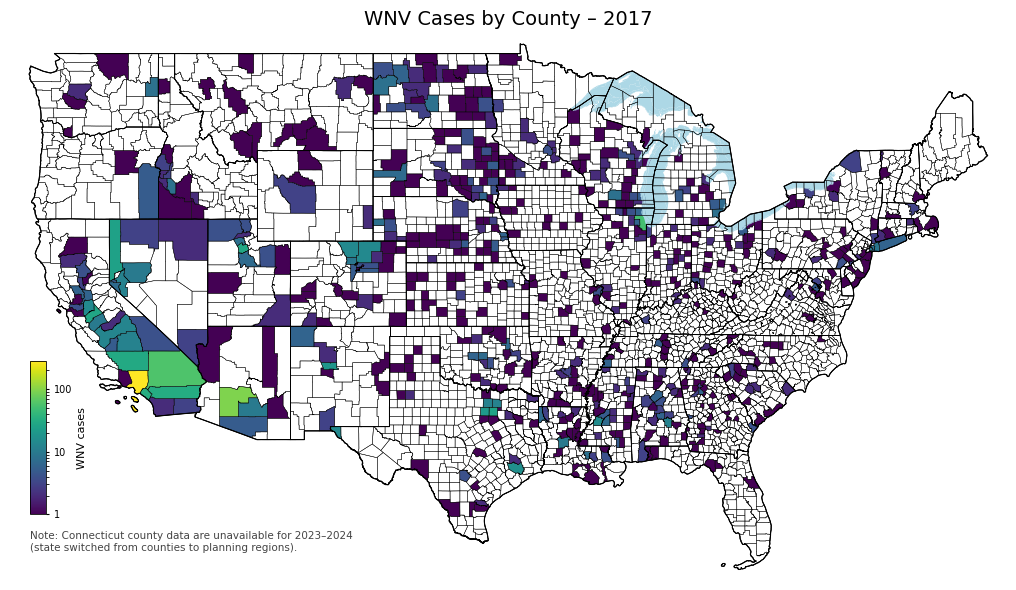

C:\Users\ITO\AppData\Local\Temp\ipykernel_19296\1908045771.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


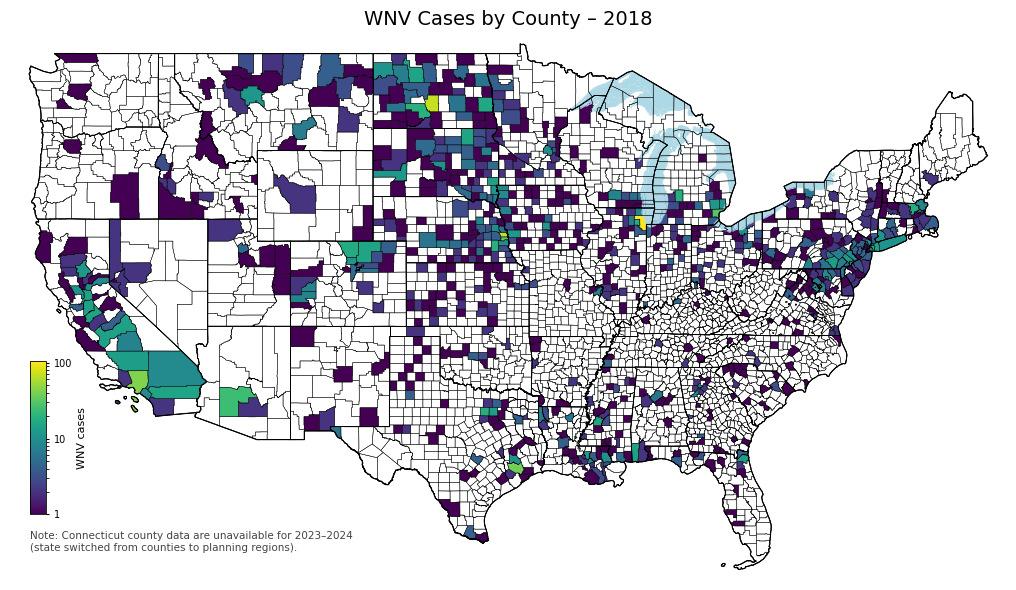

C:\Users\ITO\AppData\Local\Temp\ipykernel_19296\1908045771.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


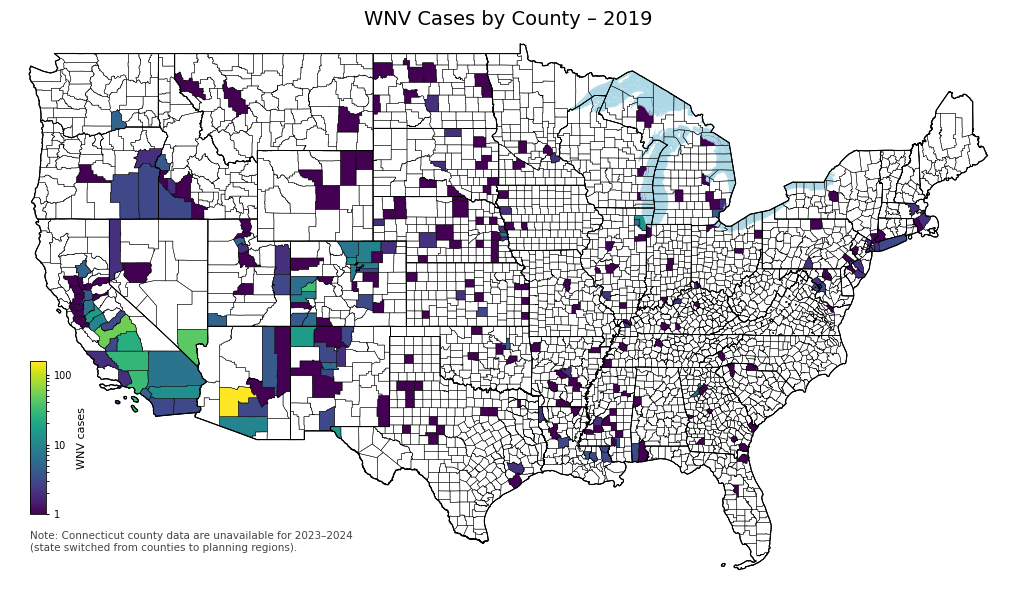

C:\Users\ITO\AppData\Local\Temp\ipykernel_19296\1908045771.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


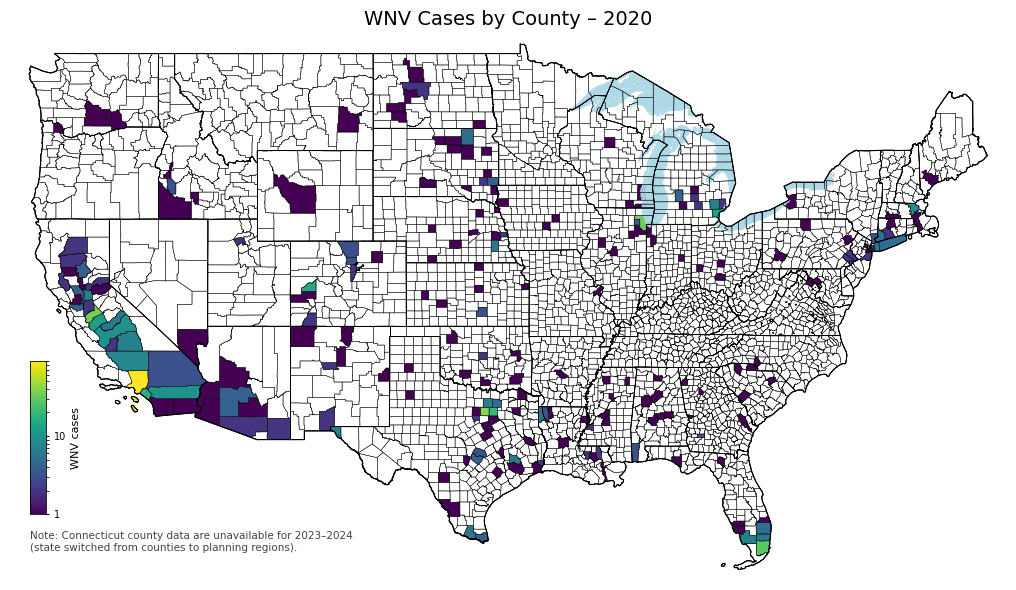

C:\Users\ITO\AppData\Local\Temp\ipykernel_19296\1908045771.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


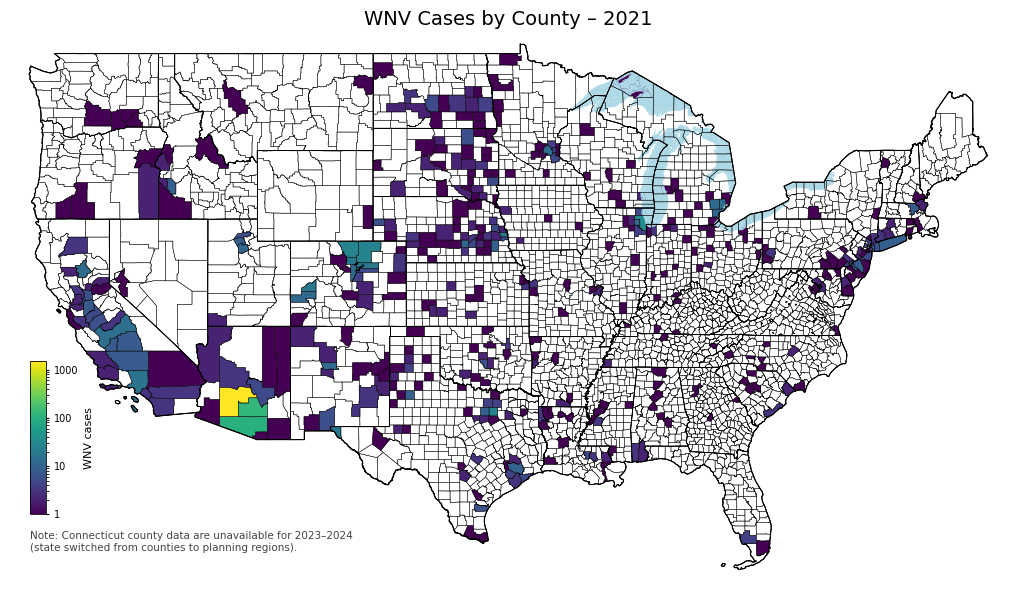

C:\Users\ITO\AppData\Local\Temp\ipykernel_19296\1908045771.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


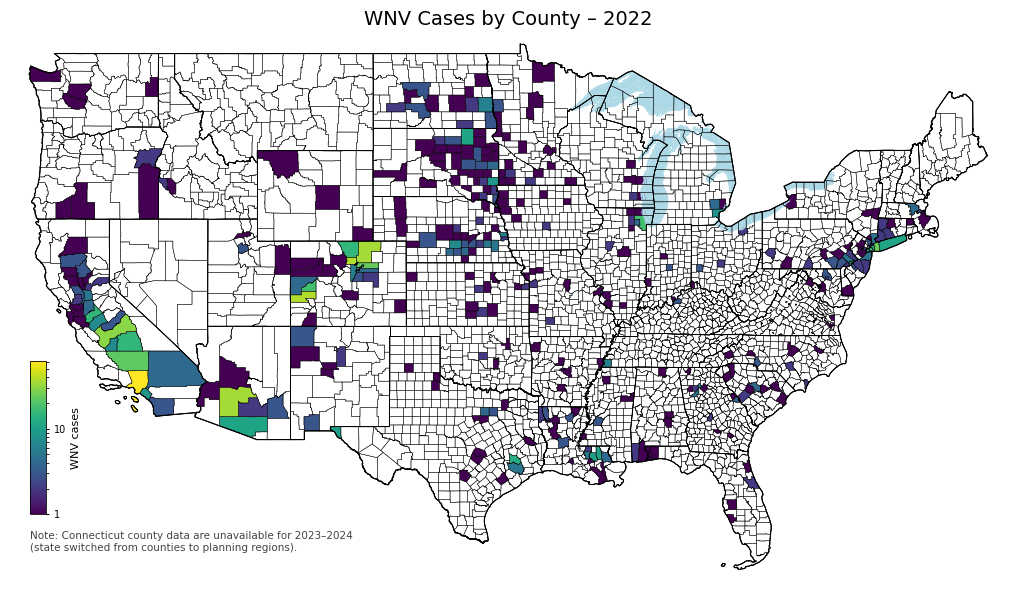

C:\Users\ITO\AppData\Local\Temp\ipykernel_19296\1908045771.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


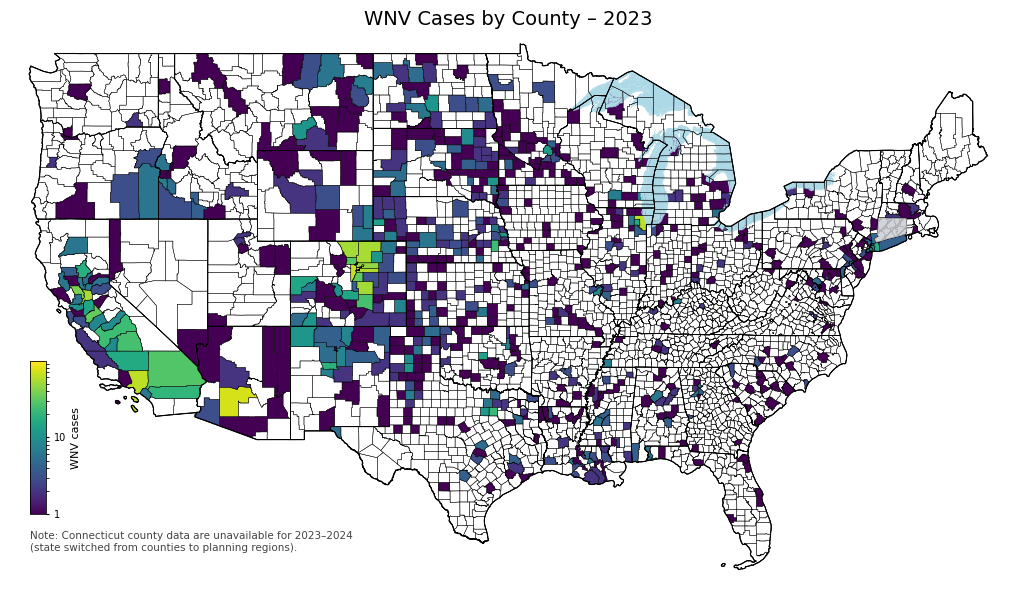

C:\Users\ITO\AppData\Local\Temp\ipykernel_19296\1908045771.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


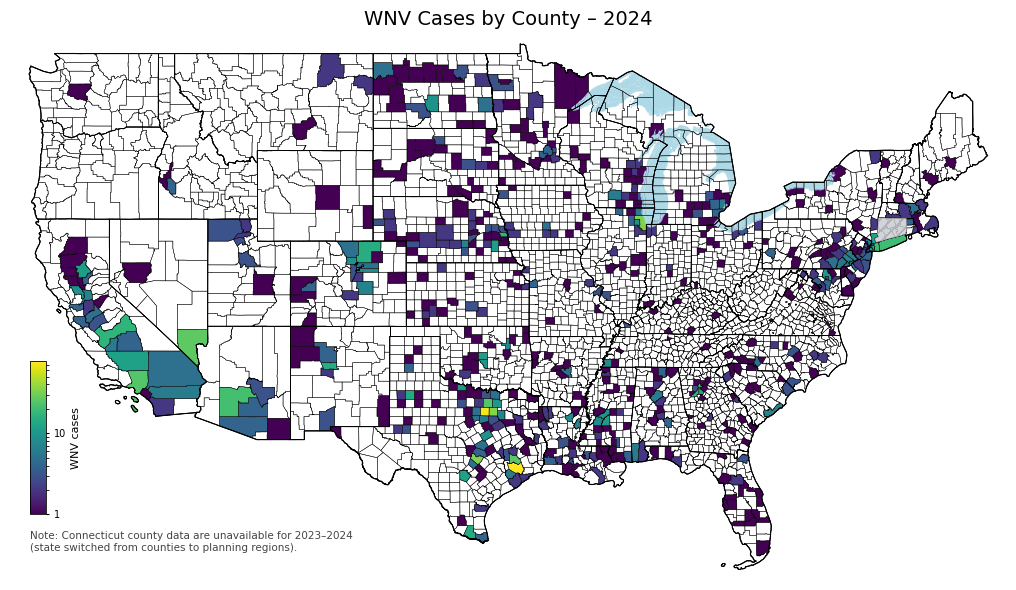

In [29]:
# only keep stuff inside the US OUTLINE (no hanging great lakes region)
water_clipped = gpd.clip(water, us_outline)

for year in range(2017, 2025):
	col = f"Cases_{year}"

	plot_df = df_merged.copy()
	plot_df.loc[plot_df[col] <= 0, col] = np.nan

	fig, ax = plt.subplots(1, 1, figsize=(12, 6))

	# add neighboring countries (probably not needed for this analysis)
	# canada.plot(ax=ax, color="gray", edgecolor="black", linewidth=0.6)
	# mexico.plot(ax=ax, color="gray", edgecolor="black", linewidth=0.6)

	plot_df.plot(
		column=col,
		ax=ax,
		cmap="viridis",
		# log norm on max
		norm=LogNorm(vmin=1, vmax=plot_df[col].max()),
		legend=False
	)

	# creating legend #
	sm = mpl.cm.ScalarMappable(
    cmap="viridis",
    norm=LogNorm(vmin=1, vmax=plot_df[col].max())
	)
	sm._A = []
	cax = inset_axes(
			ax,
			width="1.6%",     # very thin
			height="28%",     # small bar
			loc="lower left",
			bbox_to_anchor=(0.02, 0.12, 1, 1),
			bbox_transform=ax.transAxes,
			borderpad=0
	)
	cb = plt.colorbar(sm, cax=cax, format=mpl.ticker.StrMethodFormatter("{x:.0f}"))
	cb.outline.set_linewidth(0.6)
	cb.ax.tick_params(labelsize=7, length=2)
	cb.set_label("WNV cases", fontsize=8)

	# on top of everything, overlay great lakes 
	# zorder 1 for patch 
	water_clipped.plot(ax=ax, color="lightblue", linewidth=0, zorder=1)

	# for transparency, CT is grayed out for 2023 and 2024 (data not yet distributed over legacy Connecticut counties)
	ax.text(
		0.02, 0.05,
		"Note: Connecticut county data are unavailable for 2023–2024\n"
		"(state switched from counties to planning regions).",
		transform=ax.transAxes,
		fontsize=7.5,
		color="#444444",
		ha="left",
		va="bottom"
	)
	if year in [2023, 2024]:
			ct_mask = df_merged["GEOID"].str.startswith("09")
			df_merged[ct_mask].plot(
					ax=ax,
					facecolor="#D1D5DB",
					edgecolor="#AAAAAA",
					linewidth=0.3,
					zorder=2.5,
					hatch="///"
			)

	# draw US outline
	us_outline.boundary.plot(ax=ax, color="black", linewidth=0.8)
	# draw US states outline
	states.boundary.plot(ax=ax, color="black", linewidth=0.6)
	# draw US counties outline
	counties.boundary.plot(ax=ax, color="black", linewidth=0.3)

	xmin, ymin, xmax, ymax = df_merged.total_bounds

	dx = xmax - xmin
	dy = ymax - ymin

	ax.set_xlim(xmin - 0.02*dx, xmax + 0.02*dx)
	ax.set_ylim(ymin - 0.02*dy, ymax + 0.02*dy)

	ax.set_title(f"WNV Cases by County – {year}", fontsize=14)
	ax.axis("off")

	plt.tight_layout()
	plt.savefig(f"../national_embeddings/wnv_case_maps/wnv_cases_map_{year}.png")
	plt.show()

### 5. Model Evaluation